# Prediciting House Prices Using Multiple Linear Regression.

PROJECT BY: 
* Kelvin Rotich
* Grace Mutuku
* Joy Ogutu
* Peter Otieno
* Shuaib Mahamud

## Business Understanding
The real estate market in King County, Washington, which is part of the United States' Pacific Northwest, is vibrant and diverse. The county includes the thriving metropolis of Seattle, which is known for its booming tech sector, quick economic development, and gorgeous natural environs. King County's real estate market has always been characterized by a strong demand for homes, largely due to the presence of significant companies like Amazon, Microsoft, and Boeing that bring in a constant stream of workers. 

But this increase in demand has also resulted in affordability issues and a lack of homes, especially reasonably priced housing. The need for sustainable, environmentally friendly housing alternatives, urban expansion, and striking a balance between growth and protection of the environment are further challenges facing the King County real estate market. Because of this, there is fierce competition in the local real estate market, with developers, online platforms, and well-known real estate firms fighting for market share. 

Stakeholders in the area must comprehend the dynamics of the King County real estate market in addition to economic indicators, competition, and location-specific elements in order to effectively navigate the opportunities and difficulties posed by this dynamic environment.Property prices are influenced by three main categories of factors: property-specific attributes like location, size, condition, and amenities; market dynamics including supply, demand, interest rates, and economic conditions; and external factors such as neighborhood characteristics and government policies.

Understanding these factors is essential for various real estate stakeholders. Real estate agents need this knowledge to offer accurate pricing recommendations and effective marketing strategies. Homeowners can benefit from it when pricing their properties, and investors and developers can identify promising opportunities and maximize their returns.

## Problem Statement

The real estate market in King County operates in a highly dynamic environment, where economic conditions, fluctuations in housing demand, and various external factors contribute to its ever-changing nature. In this context, the repercussions of setting inappropriate property prices and making ill-informed selling decisions can be detrimental. Maximizing the selling price of a home demands a deep dive into research and market trend analysis. Key aspects to consider include evaluating property attributes such as location, size, amenities, condition, and their sensitivity to recent market shifts. By dissecting the complex web of relationships between these property characteristics and selling prices, the real estate agency endeavors to empower homeowners with the insights needed to mitigate the risks associated with pricing errors and suboptimal investment choices.

### Objectives
1. To identify and comprehend the key determinants that influence house prices.
2. Create a precise property valuation model to calculate the cost of homes depending on a range of characteristics.
3. Evaluate the model's performance in terms of its predictive accuracy.

### Importing libraries.

In [ ]:
# Importing the necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

# Data Understanding


In [ ]:
# Loading the data
data = pd.read_csv("data\kc_house_data.csv")
data.head()

Additional information of the columns:

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront 
* `view` - Quality of view from house 
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
* `grade` - Overall grade of the house. Related to the construction and design of the house.
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

The dataset contains the sale prices and details of houses sold from 2nd May 2014 to 27th May 2015.
The dataset has 21 columns with 21,597 entries.

## Data Preparation

All columns apart from `waterfront`, `view`,`yr_renovated` and `sqft_basement` have no null values

In [ ]:
# Getting information about the dataframe
data.info()

In [ ]:
#Checking for null value counts and their percentages
columns_with_missing_values = ['waterfront', 'view', 'yr_renovated']
missing_values_table = pd.DataFrame([
    {
        'Column': column,
        'Missing Count': data[column].isnull().sum(),
        'Missing Percentage': (data[column].isnull().sum() / len(data[column])) * 100
    }
    for column in columns_with_missing_values])
print(missing_values_table)

In [ ]:
# Replace the null values in yr_renovated with the most most common value '0'
data['yr_renovated'].fillna(0, inplace = True)

In [ ]:
# Replace the null values in waterfront and view with 'unknown'
data.fillna('unknown', inplace = True)

In [ ]:
#Checking for null value counts and their percentages
columns_with_missing_values = ['waterfront', 'view', 'yr_renovated']
missing_values_table = pd.DataFrame([
    {
        'Column': column,
        'Missing Count': data[column].isnull().sum(),
        'Missing Percentage': (data[column].isnull().sum() / len(data[column])) * 100
    }
    for column in columns_with_missing_values])
print(missing_values_table)

In [ ]:
# Checking for duplicate entries
data.duplicated(subset='id').sum()

In [ ]:
duplicate_rows = data[data.duplicated(subset=['id'], keep=False)].sort_values(by='id')
duplicate_rows['id'].value_counts()

### to review
177 houses were flagged as duplicates according to the `id`

In [ ]:
data.loc[data['id']==795000620 ]

In [ ]:
# Convert the datatype of date from object to datetime
data['date'] = pd.to_datetime(data['date'])

In [ ]:
# Convert the datatype of yr_built and yr_renovated form numeric to object
data.yr_built = data['yr_built'].astype('object')
data.yr_renovated = data['yr_renovated'].astype('object')

In [ ]:
# Create a function to map months to seasons
def get_season(date):
    if date.month in [3,4,5]:
        return 'Spring'
    elif date.month in [6,7,8]:
        return 'Summer'
    elif date.month in [9,10,11]:
        return 'Autumn'
    else:
        return 'Winter'

# Apply the function to the 'date' column to create a 'season' column
data['season'] = data['date'].apply(get_season)
data[['date', 'season']]

### Outliers
The presence of outliers, representing distinctive property attributes, is retained because they are genuine events that provide valuable information for predicting house prices.

In [ ]:
def check_outliers(data, columns):
    for column in columns:
        # Calculate IQR (Interquartile Range)
        iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
        
        # Define lower and upper thresholds
        lower_threshold = data[column].quantile(0.25) - 1.5 * iqr
        upper_threshold = data[column].quantile(0.75) + 1.5 * iqr

        # Find outliers
        outliers = data[(data[column] < lower_threshold) | (data[column] > upper_threshold)]

        # Print the count of outliers
        print(f"{column}\nNumber of outliers: {len(outliers)}\n")

columns_to_check = data.select_dtypes(include = ['number'])
check_outliers(data, columns_to_check)

In [ ]:
for column in data.columns:
    unique_values = data[column].unique()
    placeholders = [value for value in unique_values if str(value).strip().lower() in ['placeholder', 'na', 'n/a', '?']]
    placeholder_count = len(placeholders)
    
    print(f"Column: '{column}'")
    print(f"Placeholders found: {placeholders}")
    print(f"Count of placeholders: {placeholder_count}\n")

In [ ]:
# Replace the ? placeholder with '0.0'
data['sqft_basement'].replace('?', '0.0', inplace = True)

In [ ]:
data.sqft_basement.value_counts()

In [ ]:
data['sqft_basement'] = data['sqft_basement'].astype('float')

In [ ]:
# Checking info
data.info()

## Exploratory Data Analysis

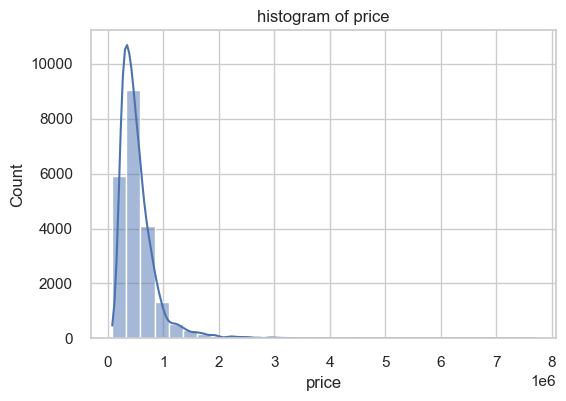

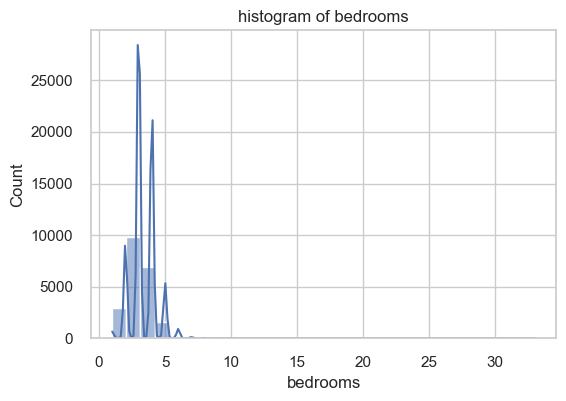

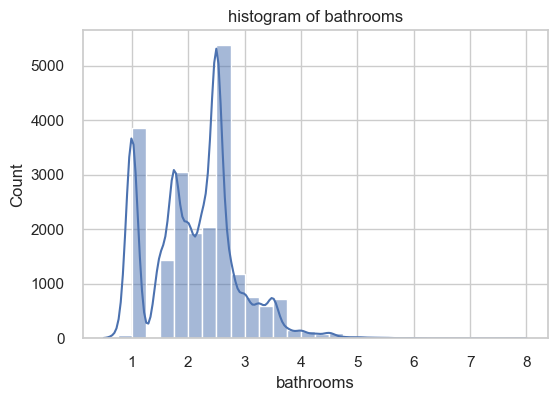

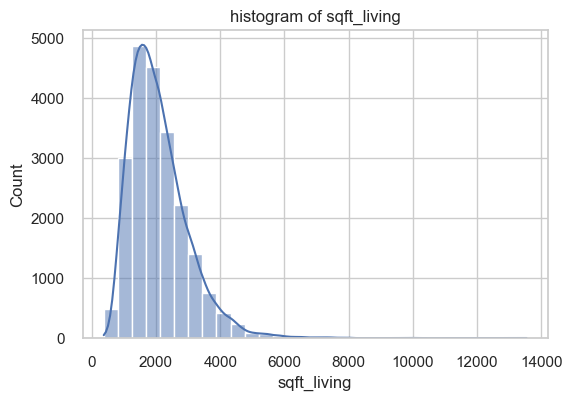

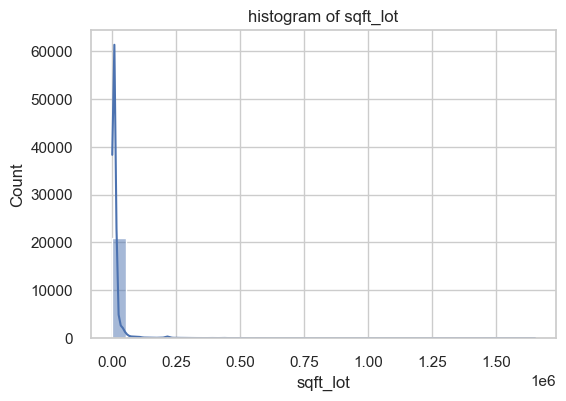

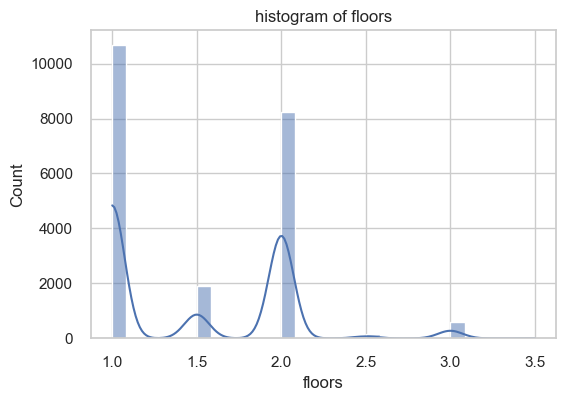

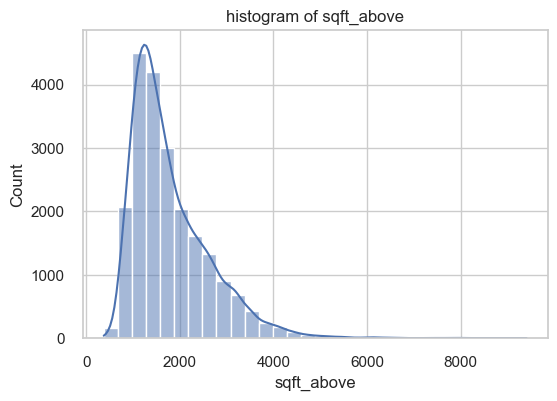

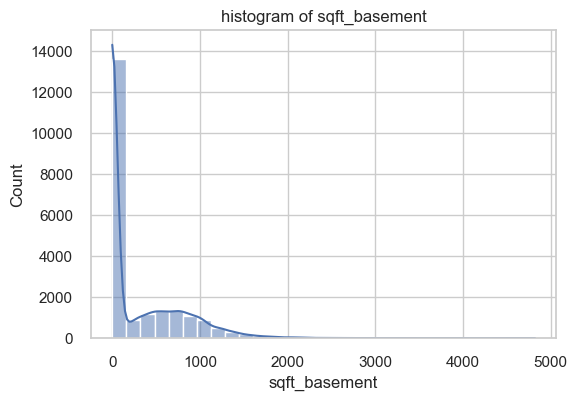

In [51]:
#creating histograms for selected columns

# Identify numerical columns
numeric_columns = data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement']]

# Iterate over numerical columns and create histograms
for column in numeric_columns.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=numeric_columns, x=column,bins = 30 ,common_norm = False, kde = True)
    plt.title(f"histogram of {column}")
    plt.show()

## HISTOGRAM SUMMARY

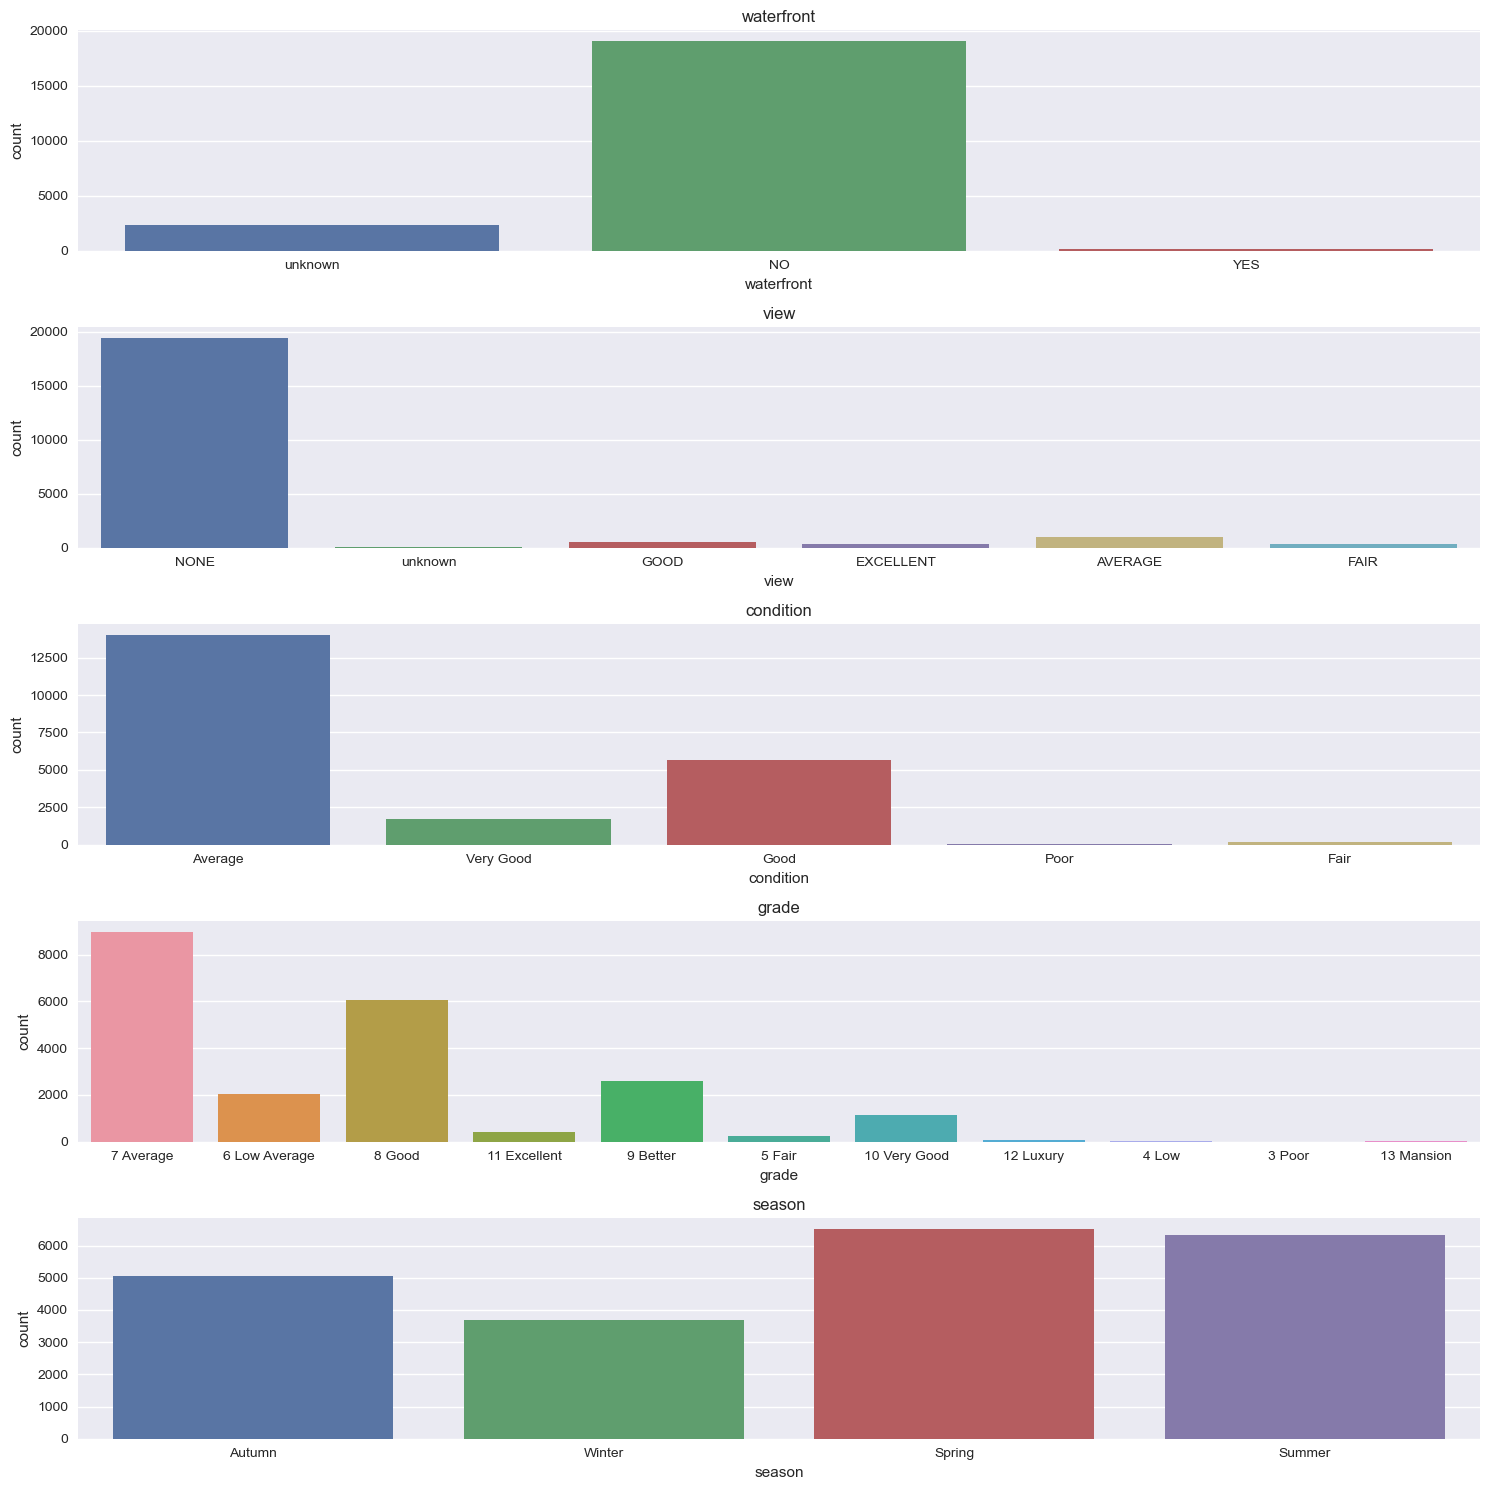

In [22]:
# creating count plots for selected columns

# Identify categorical columns
categorical_columns = data[['waterfront', 'view', 'condition', 'grade', 'season']].columns

# Create a figure with a grid of subplots
fig, axes = plt.subplots(len(categorical_columns), 1, figsize=(15, 15))

# Iterate over categorical columns and create countplots
for i, column in enumerate(categorical_columns):
    sns.countplot(data=data, x=column, ax=axes[i])
    axes[i].set_title(column)

# Show the plot
plt.tight_layout()
plt.show()

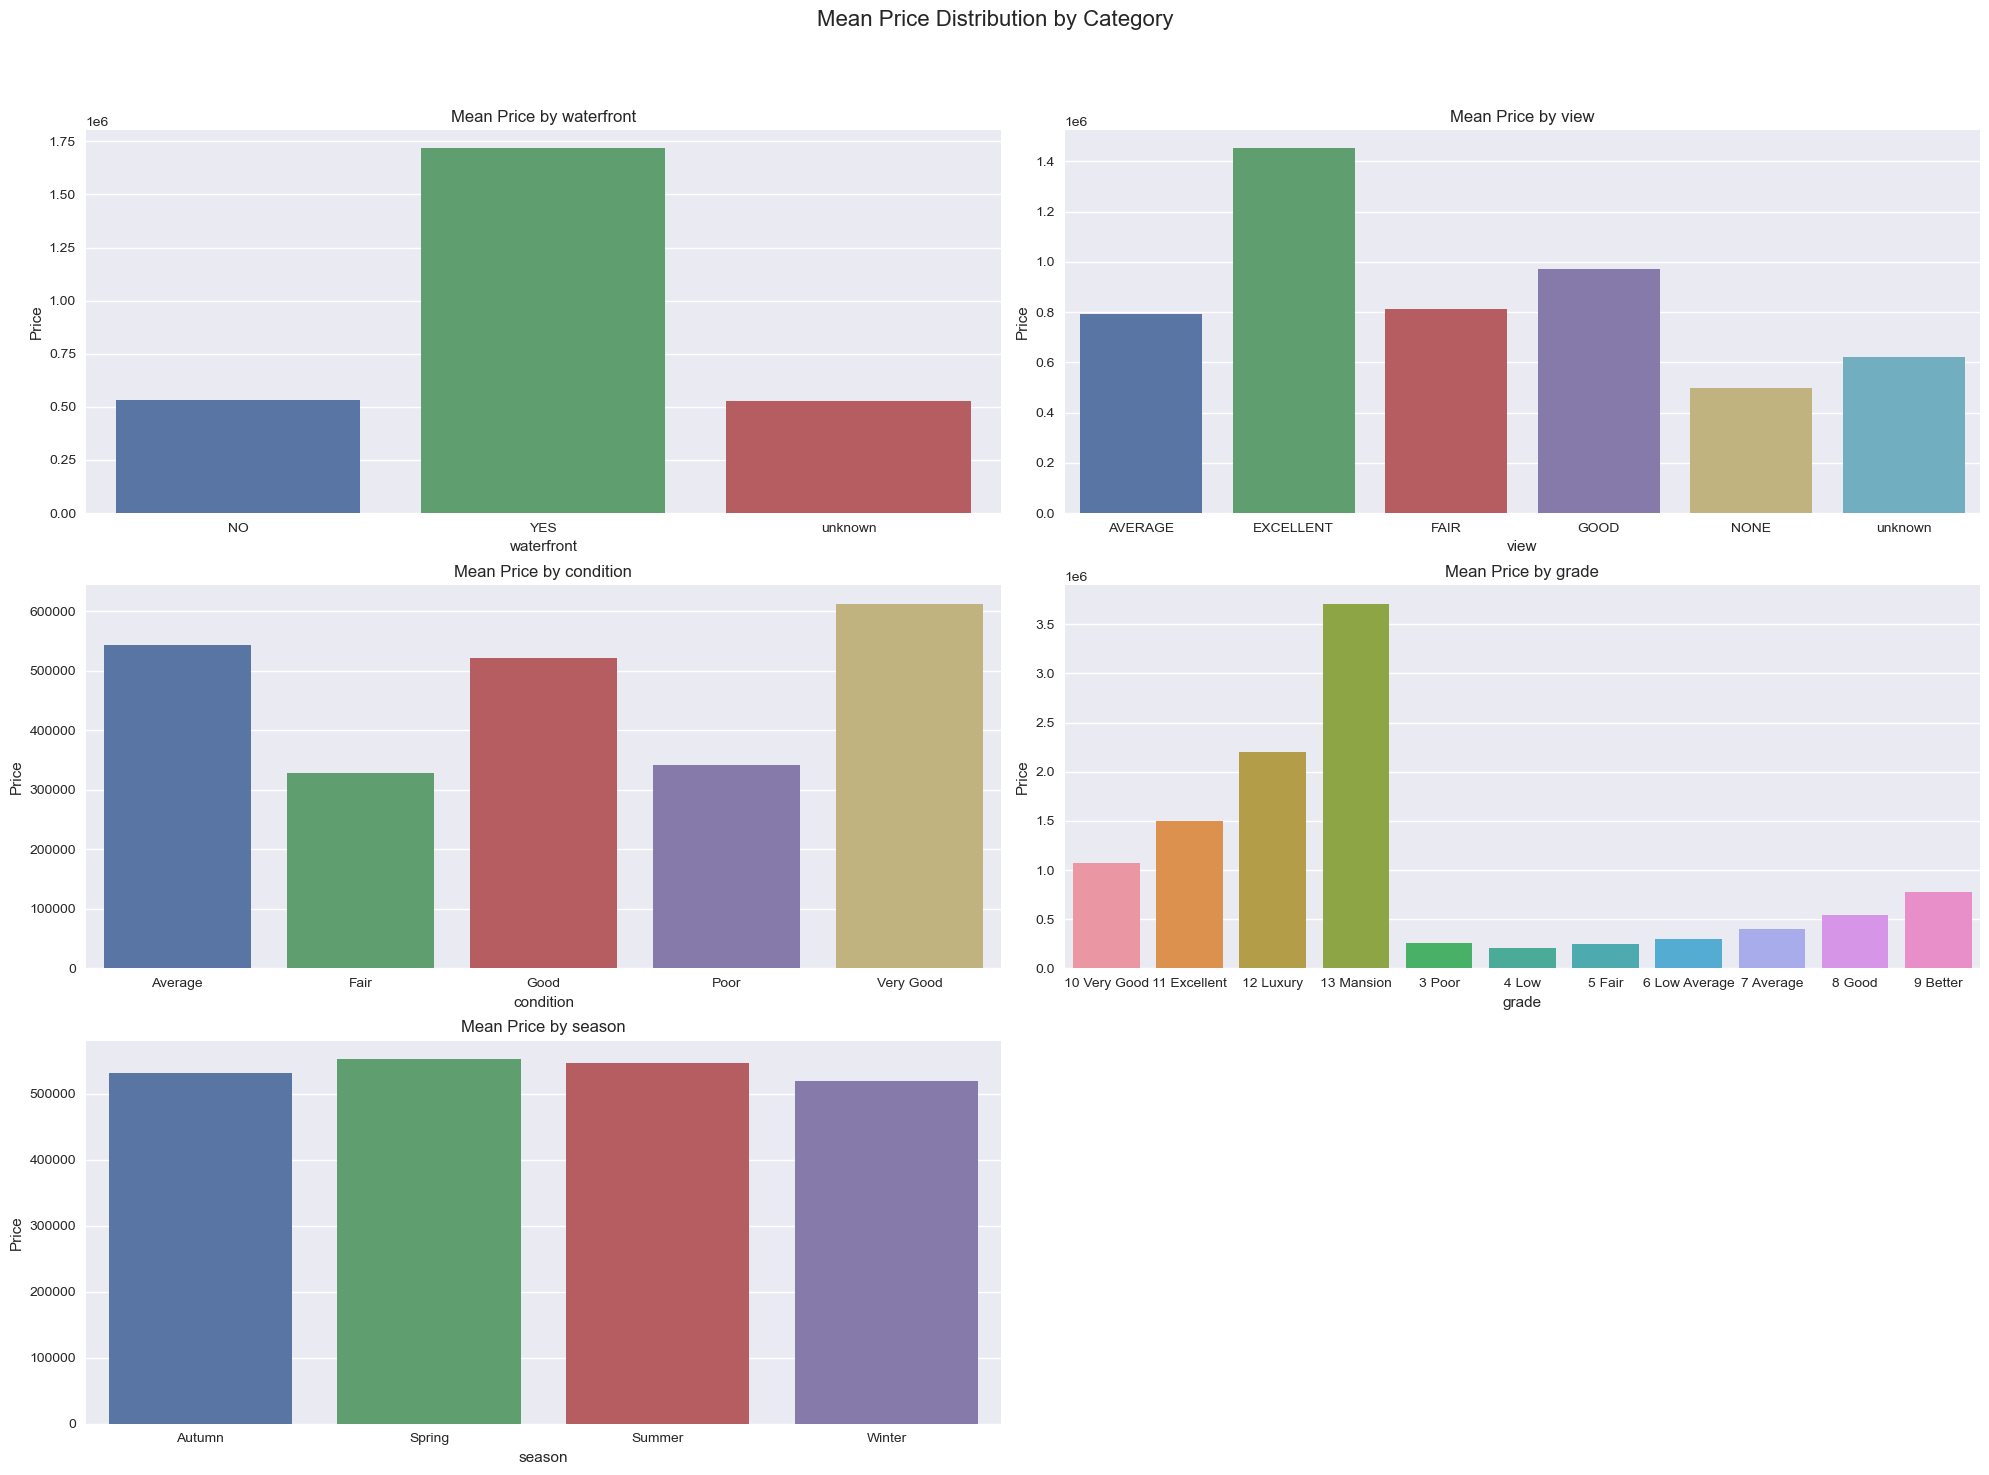

In [23]:
categories = ['waterfront', 'view', 'condition', 'grade', 'season']

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Mean Price Distribution by Category', fontsize=16)

# Loop through the categories and create bar plots
for i, category in enumerate(categories):
    row, col = i // 2, i % 2
    grouped_data = data.groupby(category)['price'].mean()
    sns.barplot(x=grouped_data.index, y=grouped_data.values, ax=axes[row, col])
    axes[row, col].set_title(f'Mean Price by {category}')
    axes[row, col].set_xlabel(category)
    axes[row, col].set_ylabel('Price')

# Remove any extra empty subplot if the number of categories is odd
if len(categories) % 2 == 1:
    fig.delaxes(axes[2, 1])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


1. The houses with waterfronts nearby were sold at high prices compared to those without waterfronts nearby

2. The houses with an excellent view had higher prices compared with the other houses
3. The houses with very good condition sold at higher prices compared to the other houses
4. The houses given a mansion grade were sold at higher prices compared to the other houses
The houses sold during spring were sold at higher prices compared to the other seasons


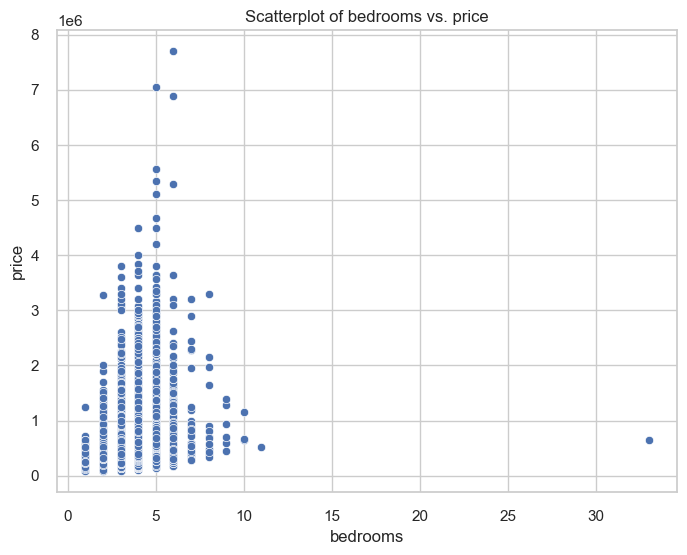

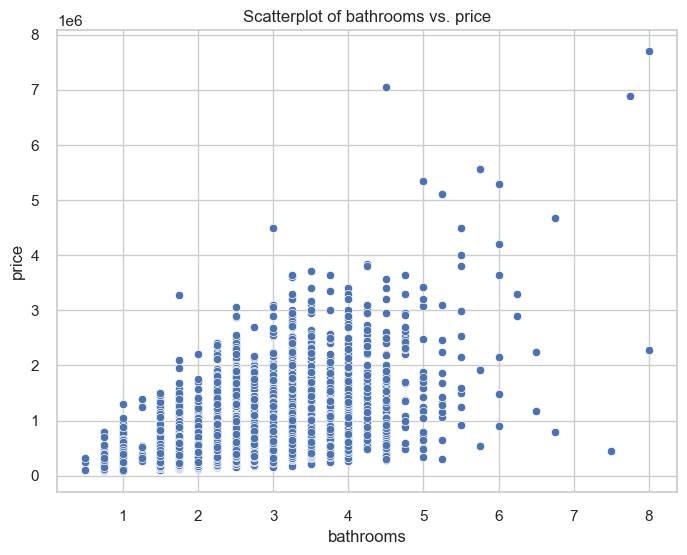

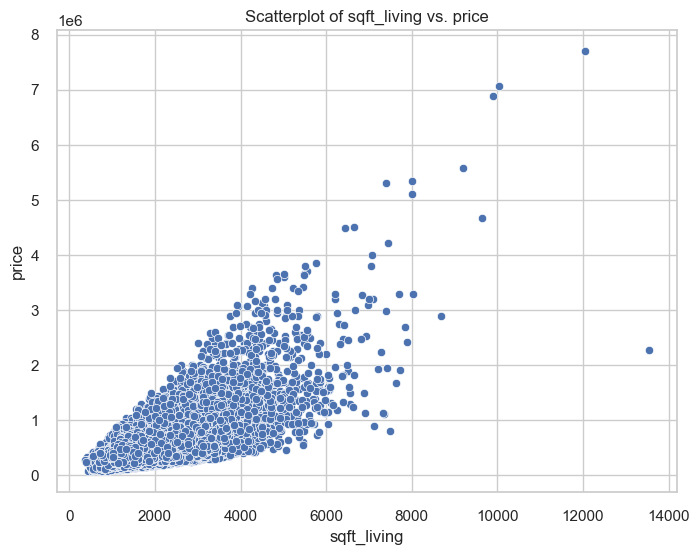

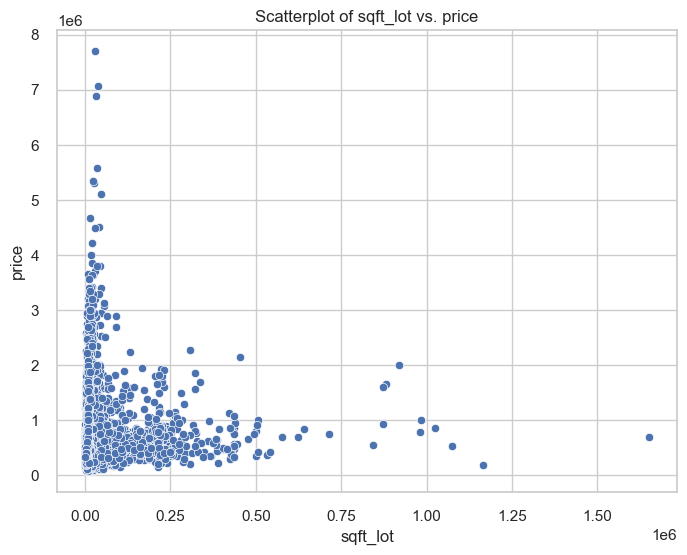

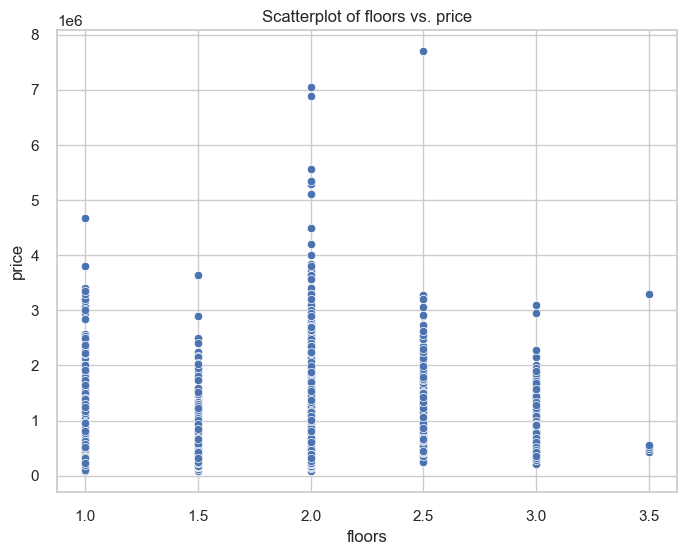

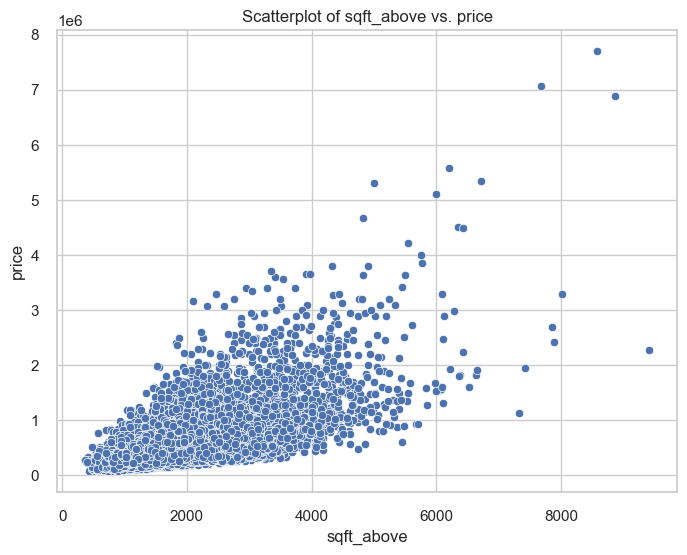

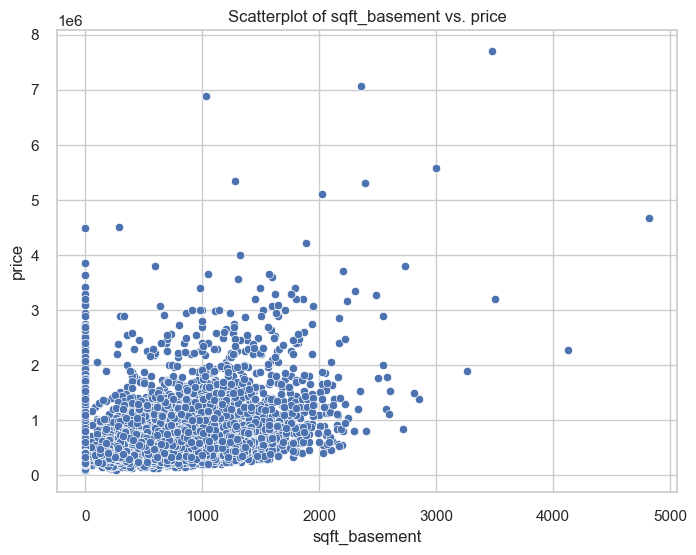

In [34]:
# setting the target column
target_column = "price"

# List of columns to create scatterplots for
columns_to_plot = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
                   'sqft_basement']

# Create scatterplots for each selected column against the target using Seaborn
for column in columns_to_plot:
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=column, y=target_column)
    plt.title(f"Scatterplot of {column} vs. {target_column}")
    plt.show()


In [26]:
# comparing correlation between price and selected features
numeric_columns = data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement']]
correlation_matrix = numeric_columns.corr()['price']
correlation_matrix

price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
sqft_lot         0.089876
floors           0.256804
sqft_above       0.605368
sqft_basement    0.321108
Name: price, dtype: float64

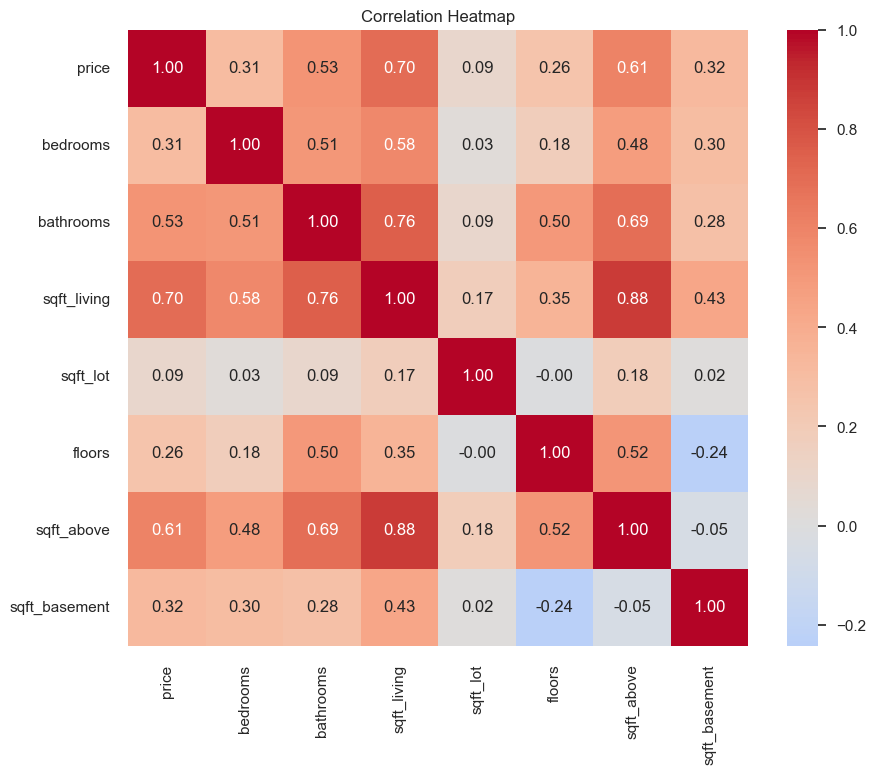

In [33]:
# craeting a heatmap
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, center=0, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()